# Lab 3: GNN Scalibility and Explanability

In this lab, you will learn how to implement scalable GNN methods and GNN explainers. Specially, you will

*   Implement different graph-based scalibility and explanability techniques
*   Analyze the performances of different scalable GNNs
*   Explain the performance of explainers

**Completion requirements**

By the end of this notebook, you should have:

*  Implement all the code cells for the scalable GNNs and GNN explainer
*  training the methods
*  assesing the performance of the methods.
 



---

## Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:

- TDC
- Numpy
- Pytorch
- NetworkX
- Matplotlib
- Scikit-learn
- Pytorch geometric  

Run the following code to import the packages

In [9]:
# import the libraries
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import copy
import os.path as osp

import torch
from torch.nn import ModuleList
import torch.nn.functional as F
from torch_geometric.nn import APPNP
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, SAGEConv, ClusterGCNConv

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.loader import ClusterData, ClusterLoader, NeighborSampler, NeighborLoader

# import the functions
from numpy import dot
import torch.nn as nn
from sklearn import metrics
from numpy.linalg import norm
import tqdm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

# import the datasets
from torch_geometric.datasets import Planetoid

## Dataset

In this lab, we will work with a benchmark dataset called **Cora**. This dataset contains 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links, indicating the citation relationship among the publications. We will treat publications as nodes and their relationship as edges in the graph.

Run the following code to load the cora dataset:

In [2]:
cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]
data.x.shape

torch.Size([2708, 1433])

## Problem Definition 

In the following two sections Lab3.1 and Lab3.2, you will perform the node classification task, where you are given a graph and its incomplete labeling, and the goal is to predict the classes of the unlabeled nodes. A tutorial to perform the node classification task on dataset Cora can be found under the link: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html

___

## Lab 3.1: Scalable GNN Methods

In this section, you will implement and analyse the performances of scalable GNN methods GraphSage and ClusterGCN. The node classification task is conducted using Cora. We will employ mini-batch training in this section. Find the tutorial on mini-batch training using pytorch geometric here: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html, and https://machinelearningmastery.com/mini-batch-gradient-descent-and-dataloader-in-pytorch/

### 🕵 <font color='289C4E'>Coding Question<font><a class='anchor' id='top'></a>

  **(a) Define and instantiate a GraphSAGE model with the following parameters:**
  
  - in_channels: the dimensions of the feature matrix in Cora
  - hidden_channels: 128
  - num_layers: 2
  - out_channels: number of classes in Cora
  - sample size for training: [5, 2]
  - learning rate: 0.01
  - batch size: 1024
  - drop out rate: 0.5
  
  **train the model for 200 epochs and record the training loss and accuracy**
  
  **visualize the training loss and accuracy on the test set as a function to the epochs**

The creation of mini-batching is crucial for letting the training of a deep learning model scale to huge amounts of data. Here, we first build data loader for training and test. Call the Neighborloader in Pytorch Geometric to build the loaders with the sample size, batch size specified above in the following cell: 

In [3]:
# for mini-batch training

num_neighbors = [5, 2]
batch_size = 1024

# build loaders to break the graph for train
train_loader = NeighborLoader(data=data, input_nodes=data.train_mask, num_neighbors=num_neighbors, batch_size=batch_size, shuffle=True)

# build loaders to break the graph for test
test_loader = NeighborLoader(data=data, input_nodes=None, num_neighbors=num_neighbors, batch_size=batch_size, shuffle=False)

In pytorch geometric, the SAGEConv layer is implemented. Here we can use the predefined SAGEConv layer to build our GraphSAGE model. Define and instantiate the GraphSAGE model in the following cell:

In [4]:
#################################################################
#add your code here to define and instantiate the GraphSAGE model
device = "cpu"
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
    
    # define the forward function here
    # note that in batch training the loss has to be backpropagated for each batch, write the function accordingly
    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    # define the inference function here
    # Compute representations of nodes layer by layer
    # This leads to faster computation in contrast to immediately computing the final representations of each batch
    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
            x_all = torch.cat(xs, dim=0)

        return x_all
    
device = torch.device('cpu')
GraphSAGE = SAGE(data.num_features, 128, cora_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(GraphSAGE.parameters(), lr=0.01)
#################################################################

According to the instructions left in the following cell, define the training and test function of the previous defined GraphSAGE model:

In [5]:
#################################################################

# define a train function for the graphsage model
def train(epoch):
    GraphSAGE.train()
    total_loss = total_correct = total_examples = 0

    # use the training loader for mini-batch training
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = GraphSAGE(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        # backpropagate the loss in this batch
        loss.backward()
        optimizer.step()
        # sum the batch loss to the total loss
        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size

    return total_loss / total_examples, total_correct / total_examples


# test function of the graphsage model
@torch.no_grad()
def test():
    GraphSAGE.eval()
    y_hat = GraphSAGE.inference(data.x, test_loader).argmax(dim=-1)
    y = data.y.to(y_hat.device)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((y_hat[mask] == y[mask]).sum()) / int(mask.sum()))
    return accs
#################################################################

Now train the model for 200 epochs in the following cell and record the training loss and accuracy on the test set:

In [6]:
train_losses=[]
test_accs = []
for epoch in range(1, 201):
    loss, acc = train(epoch)
    train_acc, val_acc, test_acc = test()
    train_losses.append(loss)
    test_accs.append(test_acc)
    print(f'epoch{epoch} loss: {loss} test acc: {test_acc}')

epoch1 loss: 1.943849802017212 test acc: 0.646
epoch2 loss: 1.564215064048767 test acc: 0.712
epoch3 loss: 1.0358400344848633 test acc: 0.745
epoch4 loss: 0.52693110704422 test acc: 0.778
epoch5 loss: 0.2217240184545517 test acc: 0.79
epoch6 loss: 0.07720384001731873 test acc: 0.786
epoch7 loss: 0.030041541904211044 test acc: 0.793
epoch8 loss: 0.01732436567544937 test acc: 0.786
epoch9 loss: 0.005787429865449667 test acc: 0.779
epoch10 loss: 0.003130833152681589 test acc: 0.769
epoch11 loss: 0.0007719643763266504 test acc: 0.773
epoch12 loss: 0.0005968977347947657 test acc: 0.771
epoch13 loss: 0.00047781472676433623 test acc: 0.767
epoch14 loss: 0.000157305650645867 test acc: 0.767
epoch15 loss: 0.0002042960113612935 test acc: 0.761
epoch16 loss: 8.015501225600019e-05 test acc: 0.77
epoch17 loss: 5.154100654181093e-05 test acc: 0.767
epoch18 loss: 7.249178452184424e-05 test acc: 0.769
epoch19 loss: 4.414904833538458e-05 test acc: 0.775
epoch20 loss: 6.276712520048022e-05 test acc: 0.7

**In the following two cells, visualize the training loss and accuracy on the test set as a function to the epochs**

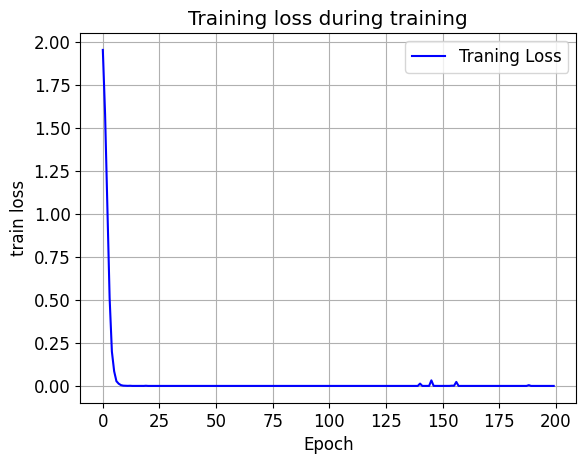

In [7]:
#################################################################
# add your code here to plot the training loss to epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(train_losses, 'b-', label='Traning Loss')

# Add a legend to the plot
ax.legend(loc='upper right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('train loss')
ax.set_title('Training loss during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
#################################################################

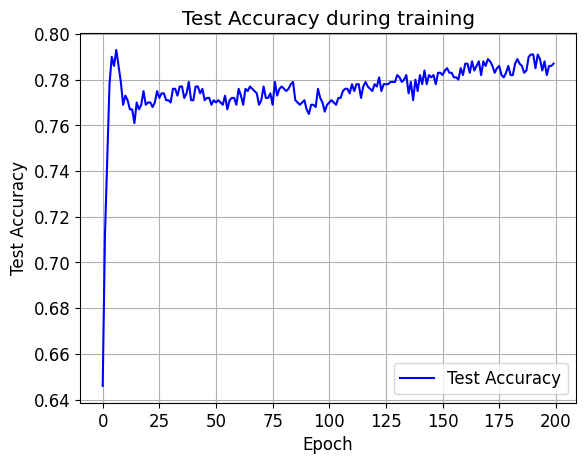

In [7]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_accs, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

___

### 🕵 <font color='289C4E'>Coding Question<font><a class='anchor' id='top'></a>

 **(b.1) Define and instantiate a ClusterGCN model with the following parameters:**
  - convolution layer: SAGEConv
  - num_layers: 2
  - in_channels: the dimensions of the feature matrix in Cora
  - hidden_channels: 128
  - out_channels: number of classes in Cora
  - learning rate: 0.01
  - train loader batch size: 20
  - test loader batch size: 1024
  - drop out: 0.5
  - num parts: 400
  
  **train it for 20 epochs and record the training loss and accuracy**
  
  **plot the training loss and accuracy on the test set as a function to the epochs**

For clusterGCN, we call the ClusterData from torch_geometric.loader to break the original graphs into communities. Use the number of communities defined above as num_parts. Use the ClusterLoader to build data loader using the communities, specify the batch size as given above.

In [1]:
from torch_geometric.loader import ClusterData, ClusterLoader, NeighborSampler, NeighborLoader
from torch_geometric.datasets import Planetoid

cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]

num_parts = 400
cluster_data = ClusterData(data, num_parts=num_parts, recursive=False,
                           save_dir=cora_dataset.processed_dir)

train_loader = ClusterLoader(cluster_data, batch_size=20, shuffle=True,
                             num_workers=12)

subgraph_loader = NeighborSampler(data.edge_index, sizes=[-1], batch_size=1024,
                                  shuffle=False, num_workers=12)

: 

: 

### 🕵 <font color='289C4E'>Coding Question<font><a class='anchor' id='top'></a>

Define and instantiate the ClusterGCN using the SAGEConv layer from torch_geometric package in the following cell

In [ ]:
#################################################################
# add your code here to define and instantiate the ClusterGCN
class ClusterGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # define the layers here
        
    # define a forward function for the ClusterGCN
    # we should also use batches befined in the loader
    def forward(self, x, edge_index):
        
        return 

    def inference(self, x_all):
       
        return
    

model = ClusterGCN(...)
optimizer = 
#################################################################

In [ ]:
#################################################################
# add your code here to train the ClusterGCN for 200 epochs
# and record the training loss and accuracy on test set

# define training function here
def train():
   

    return

# Inference should be performed on the full graph.
@torch.no_grad()
def test():  
    
    return

# train the model here for 200 epochs
# record the loss and test accuracy during training


In [ ]:
#################################################################
# add your code here to plot the training loss to epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(train_losses, 'b-', label='Traning Loss')

# Add a legend to the plot
ax.legend(loc='upper right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('train loss')
ax.set_title('Training loss during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
#################################################################

In [ ]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_accs, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

**(b.1)What would happen in the training if we specify a very high number of communities, for example 1500 in the ClusterData object? Implement the ClusterGCN with 1500 communities in the following cell and observe the training loss and test accurracy to draw your conclusion.**

In [ ]:
cluster_data = ClusterData(...)
train_loader = ClusterLoader(...)

subgraph_loader = NeighborSampler(...)

model = ClusterGCN(...)
optimizer=

#train the model for 200 epochs here



**Answer Here:**

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(c.1)Which method did you expect to converge faster. Explain why in the following cell**

**Answer here:** 

**(c.2)Which method converges faster in your experiments**

**Answer here:** 

**(c.3)In case your observations about convergence of the compared method differ from your expectations, what could have contributed to this difference?**

**Answer here:** 

### 🕵 <font color='289C4E'>Coding Question<font><a class='anchor' id='top'></a>

**(e)Try here 10 and 20 layers of GraphSAGE and ClusterGCN with the same parameters as defined in two layers GraphSAGE and ClusterGCN. From your observations which method would you prefer when increasing the layers and give your reasons in the following cell.**

In [ ]:
######################################################################### 
#Run 10 layer Graphsage here

######################################################################### 

In [ ]:
######################################################################### 
#Run 20 layer Graphsage here

######################################################################### 

In [ ]:
######################################################################### 
#Run 10 layer ClusterGCN here

######################################################################### 

In [ ]:
######################################################################### 
#Run 20 layer ClusterGCN here

######################################################################### 

**Answer here:** 

---

## Lab 3.2: Explanability of GNNs

**Description:**

In this section, you will extract and analyse the explainations from GNNExplainer and Zorro on Cora. 

To do this, we firstly train a basic GCN with default parameters to perform the node classification task. This trained GCN will then be used as the target model to explain by the GNNExplainer and Zorro. We randomly choose ten nodes from Cora to produce explanations. The explainations indicate which features and neighboring nodes/edges are crucial for the ego nodes in the node classification task. Finally, we compare and analyse the explanations extracted by GNNExplainera and Zorro using RDT-fidelity and sparsity.



Note the explainers may produce different explanations for different nodes. In order to make the anwser correctable, we randomly choose 10 nodes with indices [116, 198, 224, 650, 808, 1017, 1706, 1733, 2172, 2433] for this question. Run the following code to extract their features from the feature matrix of Cora.

In [ ]:
ind = [116, 198, 224, 650, 808, 1017, 1706, 1733, 2172, 2433]
feat = data.x[ind]

Now we train a GCN model with the following parameters for 100 epochs:

  - in_channels: the dimensions of the feature matrix in Cora
  - hidden_channels: 16
  - num_layers: 2
  - out_channels: number of classes in Cora
  - learning rate: 0.01
  - drop out: 0.5
  - weight_decay: 5e-4

In the following cell, we provide the code to define and instanstiate a GCN model using the previouly given parameters:

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x
    
model = GCN(cora_dataset.num_features, 16, cora_dataset.num_classes)

Now we train the GCN model instantiated in the previous cell for 100 epochs using the built in train, validation, and test split in Cora

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, test: {test_acc:.4f}')

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(a)Extract explanation for the above mentioned 10 nodes using GNNExplainer using the following paramters:**

    - epochs: 100
    - model: the previously trained GCN
    - top_k: extract importance of top 50 features
    
**GNNExplainer is implemented in torch_geometric. Instantiate GNNExplainer by filling the blanks in the follwing cell.**
    
**Visualize the importances assigned to each feature by GNNExplainer**

In [ ]:
##################################################################################
#add your code here to generate explanations using GNNExplainer
explainer = 

# explanations for each node

##################################################################################

In [ ]:
##################################################################################
#add your code here to visualize the feature importance

##################################################################################

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(b)Calculate the RDT fidelity of the explanations extracted from GNNExplainer**

The following function calculate the k-hop subgraph of the given target nodes. This function will be called in the calculation of the RDT-Fidelity.

In [ ]:
def subgraph(model, node_idx, x, edge_index, **kwargs):
    num_nodes, num_edges = x.size(0), edge_index.size(1)

    flow = 'source_to_target'
    for module in model.modules():
        if isinstance(module, MessagePassing):
            flow = module.flow
            break

    num_hops = 0
    for module in model.modules():
        if isinstance(module, MessagePassing):
            if isinstance(module, APPNP):
                num_hops += module.K
            else:
                num_hops += 1

    subset, edge_index, mapping, edge_mask = k_hop_subgraph(
        node_idx, num_hops, edge_index, relabel_nodes=True,
        num_nodes=num_nodes, flow=flow)

    x = x[subset]
    for key, item in kwargs:
        if torch.is_tensor(item) and item.size(0) == num_nodes:
            item = item[subset]
        elif torch.is_tensor(item) and item.size(0) == num_edges:
            item = item[edge_mask]
        kwargs[key] = item

    return x, edge_index, mapping, edge_mask, kwargs

Zorro outputs feature_mask and node_mask. In order to make the comparision later between the explainers, use the following code snippet to convert the edge_mask produced by GNNExplainer to node_mask:

In [ ]:
def edge_mask_to_node_mask(data, edge_mask, aggregation="mean"):

    node_weights = torch.zeros(data.x.shape[0])

    if aggregation == "sum":

        for weight, nodes in zip(edge_mask, data.edge_index.T):
            node_weights[nodes[0].item()] += weight.item() / 2
            node_weights[nodes[1].item()] += weight.item() / 2

    elif aggregation == "mean":

        node_degrees = torch.zeros(data.x.shape[0])

        for weight, nodes in zip(edge_mask, data.edge_index.T):

            node_weights[nodes[0].item()] += weight.item()

            node_weights[nodes[1].item()] += weight.item()

            node_degrees[nodes[0].item()] += 1

            node_degrees[nodes[1].item()] += 1

        node_weights = node_weights / node_degrees.clamp(min=1.)

    elif aggregation == "max":

        for weight, nodes in zip(edge_mask, data.edge_index.T):

            node_weights[nodes[0].item()] = max(weight.item(), node_weights[nodes[0].item()])

            node_weights[nodes[1].item()] = max(weight.item(), node_weights[nodes[1].item()])

    else:

        raise NotImplementedError(f"No such aggregation method: {aggregation}")

    return node_weights

In [ ]:
# convert the edge mask to node mask here



In the following cell is the incomplete function to calculate the RDT-Fidelity. Read the code and fill the blank in the follwing cell to complete the function of calculating RDT-Fidelity:

In [ ]:
# The function to return the k-hop subgraph of the selected nodes
def fidelity(model,  # is a must
             node_idx,  # is a must
             full_feature_matrix,  # must
             edge_index=None,  # the whole, so data.edge_index
             node_mask=None,  # at least one of these three node, feature, edge
             feature_mask=None,
             edge_mask=None,
             samples=100,
             random_seed=12345,
             device="cpu"
             ):
    """
    Distortion/Fidelity (for Node Classification)
    :param model: GNN model which is explained
    :param node_idx: The node which is explained
    :param full_feature_matrix: The feature matrix from the Graph (X)
    :param edge_index: All edges
    :param node_mask: Is a (binary) tensor with 1/0 for each node in the computational graph
    => 1 means the features of this node will be fixed
    => 0 means the features of this node will be pertubed/randomized
    if not available torch.ones((1, num_computation_graph_nodes))
    :param feature_mask: Is a (binary) tensor with 1/0 for each feature
    => 1 means this features is fixed for all nodes with 1
    => 0 means this feature is randomized for all nodes
    if not available torch.ones((1, number_of_features))
    :param edge_mask:
    :param samples:
    :param random_seed:
    :param device:
    :param validity:
    :return:
    """
    if edge_mask is None and feature_mask is None and node_mask is None:
        raise ValueError("At least supply one mask")

    computation_graph_feature_matrix, computation_graph_edge_index, mapping, hard_edge_mask, kwargs = subgraph(model, node_idx, 
                                                                                                               full_feature_matrix, 
                                                                                                               edge_index)

    # get predicted label
    log_logits = model.forward(x=computation_graph_feature_matrix,
                               edge_index=computation_graph_edge_index)
    predicted_labels = log_logits.argmax(dim=-1)

    predicted_label = predicted_labels[mapping]

    # fill missing masks
    if feature_mask is None:
        (num_nodes, num_features) = full_feature_matrix.size()
        feature_mask= torch.ones((1, num_features), device=device)

    num_computation_graph_nodes = computation_graph_feature_matrix.size(0)
    if node_mask is None:
        # all nodes selected
        node_mask = torch.ones((1, num_computation_graph_nodes), device=device)


    # set edge mask
    if edge_mask is not None:
        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = edge_mask
    (num_nodes, num_features) = full_feature_matrix.size()

    num_nodes_computation_graph = computation_graph_feature_matrix.size(0)

    # retrieve complete mask as matrix
    mask = node_mask.T.matmul(feature_mask)

    correct = 0.0

    rng = torch.Generator(device=device)
    rng.manual_seed(random_seed)
    random_indices = torch.randint(num_nodes, (samples, num_nodes_computation_graph, num_features),
                                   generator=rng,
                                   device=device,
                                   )
    random_indices = random_indices.type(torch.int64)
    
    
    ###################################################################################################
    # for each samples, add your code here to:
    for i in range(samples):
        
        #1. generate the perturbed input
        
        
        #2. get the prediction from the trained model using the perturbed features as input
        
       
        
        #3. calculate the number of corrected predicted labels:
       
    ###################################################################################################
    
    # reset mask
    if edge_mask is not None:
        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None

    return correct / samples

calculate the RDT-Fidelity of the extracted feature and node explanations:

In [ ]:
# for each node calculate the rdt fidelity for the feature and node mask


**Answer here Fidelity for GNNExplainer:**

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(c)Repeat (a) and (b) to extract explanation for the above mentioned 10 nodes using Zorro with the following paramters:**

    - model:GCN
    - tau: 0.03
    - samples: 100

We provide the implementation of Zorro in this experiment, you can import it from explainer.py using the following code:

In [ ]:
from explainer import Zorro

Using the following function to extract explanations for the nodes

In [ ]:
def get_zorro(index):
    # Same as the 0.98 in the paper
    tau = .03
    # only retrieve 1 explanation
    recursion_depth = 1

    explanation = 


    return selected_features, selected_nodes

extract explanations for the above mentioned 10 nodes using Zorro

In [ ]:
##################################################################################
#add your code here to extract explanations using Zorro

##################################################################################

In [ ]:
##################################################################################
#add your code here to visualize the feature importances generated by Zorro

##################################################################################

**Calculate the fidelity for the extracted explanations**

In [ ]:
##################################################################################
# for each node calculate the rdt fidelity for the feature and node mask

##################################################################################

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(d)Compare the importances asssigned to the features by GNNExplainer and Zorro, what do you observe from the distribution plots and what does this difference mean?**

**Answer here: **

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(e)Compare the explanations extracted by GNNExplainer and Zorro, Which explainer is more faithful to the model and explain why?**

**Answer:**

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(f)Use number of samples [5, 10, 20, 50] in optimizing fidelity for generating Zorro's explanations. Calculate the the RDT-Fidelity for the corresponding explanations of Zorro. What do you conclude about the performance-speed tradeoff of Zorro from the results?**

In [ ]:
############################################################
# add your code here to calculate RDT-Fidelity using 5 samples
# for each node calculate the rdt fidelity for the feature and node mask

############################################################

In [ ]:
############################################################
# add your code here to calculate RDT-Fidelity using 10 samples
# for each node calculate the rdt fidelity for the feature and node mask

############################################################

In [ ]:
############################################################
# add your code here to calculate RDT-Fidelity using 20 samples
# for each node calculate the rdt fidelity for the feature and node mask

############################################################

In [ ]:
############################################################
# add your code here to calculate RDT-Fidelity using 50 samples
# for each node calculate the rdt fidelity for the feature and node mask

############################################################

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(g)Compare the RDT-Fidelity of the new explanations of Zorro with that of GNNExplainer. What do you conclude from the performance of explanations? **

**Answer**:**

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(h.1) Define the function to calculate the sparsity of the explanations by computing the entropy of the feature masks.**

In [ ]:
from scipy.stats import entropy
##################################################################################
# add your code here to define the function of calculating the sparsity of the explanations
def sparsity(...):
    
##################################################################################

**(h.2)Calculate the sparsity of the feature explanation extracted by GNNExplainer**

In [ ]:
##################################################################################
#add your code here 
# for each node calculate the rdt fidelity for the feature and edge mask

##################################################################################

**(f.3)Calculate the sparsity of the feature explanation extracted by Zorro**

In [ ]:
##################################################################################
#add your code here 

##################################################################################

**(f.4)Which explanation is more useful with respect to its sparsity and why?**

**Answer**

---